# House prices

Kairos (April 2018)

## Description
Ask a home buyer to describe their dream house, and they probably won't begin with the height of the basement ceiling or the proximity to an east-west railroad. But this playground competition's dataset proves that much more influences price negotiations than the number of bedrooms or a white-picket fence.

## Data
79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

## Challenge
Predicting the final price of each home.

## Method
We'll use Tensorflow as out method to develop the project.

# Sparsity and L1 Regularization

* Calculate the size of a model
* Apply L1 regularization to reduce the size of a model by increasing sparsity

One way to reduce complexity is to use a regularization function that encourages weights to be exactly zero. For linear models such as regression, a zero weight is equivalent to not using the corresponding feature at all. In addition to avoiding overfitting, the resulting model will be more efficient.

L1 regularization is a good way to increase sparsity.

## 1. Set Up
In this first cell, we'll load the necessary libraries.

In [1]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format


/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## 2. Load our data set
Next, we'll load our data set and show information about it.

In [2]:
housing_dataframe = pd.read_csv("input/cleaned_houses_prices_train.csv", sep=",")
housing_dataframe.shape
housing_dataframe.describe()
housing_dataframe.info()
housing_dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451 entries, 0 to 1450
Data columns (total 65 columns):
Id               1451 non-null int64
MSSubClass       1451 non-null int64
LotArea          1451 non-null int64
OverallQual      1451 non-null int64
OverallCond      1451 non-null int64
YearBuilt        1451 non-null int64
YearRemodAdd     1451 non-null int64
MasVnrArea       1451 non-null float64
BsmtFinSF1       1451 non-null int64
BsmtFinSF2       1451 non-null int64
BsmtUnfSF        1451 non-null int64
TotalBsmtSF      1451 non-null int64
1stFlrSF         1451 non-null int64
2ndFlrSF         1451 non-null int64
LowQualFinSF     1451 non-null int64
GrLivArea        1451 non-null int64
BsmtFullBath     1451 non-null int64
BsmtHalfBath     1451 non-null int64
FullBath         1451 non-null int64
HalfBath         1451 non-null int64
BedroomAbvGr     1451 non-null int64
KitchenAbvGr     1451 non-null int64
TotRmsAbvGrd     1451 non-null int64
Fireplaces       1451 non-null int64
Gar

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,Foundation,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,PavedDrive,SaleType,SaleCondition
0,1,60,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,0,0,0,0,0,0,0
1,2,20,9600,6,8,1976,1976,0.0,978,0,...,1,0,0,0,0,1,0,0,0,0
2,3,60,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70,9550,7,5,1915,1970,0.0,216,0,...,2,0,1,0,0,0,0,0,0,1
4,5,60,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,1456,60,7917,6,5,1999,2000,0.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1447,1457,20,13175,6,6,1978,1988,119.0,790,163,...,1,0,2,0,0,1,1,0,0,0
1448,1458,70,9042,7,9,1941,2006,0.0,275,0,...,5,0,0,0,0,0,0,0,0,0
1449,1459,20,9717,5,6,1950,1996,0.0,49,1029,...,1,0,1,0,2,0,0,0,0,0


In [3]:
# Create a synthetic feature.
# Create a new category for total habitable surface
housing_dataframe["habitableSF"] = housing_dataframe["1stFlrSF"] + housing_dataframe["2ndFlrSF"] + housing_dataframe["GrLivArea"]
#housing_dataframe['SQMeter_price'] = housing_dataframe.apply(lambda row: row['SalePrice'] / row['habitableSF'], axis=1)
housing_dataframe['SQMeter_price'] = 0  

Note how the code below is slightly different from the previous exercises. Instead of using `SalePrice` as target, we create a new binary target, `SalePrice_value_is_high`.

In [4]:
def preprocess_features(housing_dataframe):
  """Prepares input features from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = housing_dataframe[
    ["YearRemodAdd",
     "BedroomAbvGr",
     "OverallCond"]]
  processed_features = selected_features.copy()
  
 
  # Create a new synthetic feature
  processed_features['SQMeter_price'] = ( 
    housing_dataframe['SalePrice'] / 
    housing_dataframe['habitableSF'])

  return processed_features

def preprocess_targets(housing_dataframe):
  """Prepares target features (i.e., labels) from housing data set.

  Args:
    housing_dataframe: A Pandas DataFrame expected to contain data
      from the housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Create a boolean categorical feature representing whether the
  # SalePrice is above a set threshold.
  output_targets["SalePrice_value_is_high"] = (
    housing_dataframe["SalePrice"] > 215000).astype(float)
  return output_targets

## 3. Splitting

In [5]:
# Choose the first 1000 (out of 1451) examples for training.
training_examples = preprocess_features(housing_dataframe.head(1000))
training_targets = preprocess_targets(housing_dataframe.head(1000))

# Choose the last 500 (out of 1451) examples for validation.
validation_examples = preprocess_features(housing_dataframe.tail(500))
validation_targets = preprocess_targets(housing_dataframe.tail(500))

# Double-check that we've done the right thing.
print "Training examples summary:"
display.display(training_examples.describe())
print "Validation examples summary:"
display.display(validation_examples.describe())

print "Training targets summary:"
display.display(training_targets.describe())
print "Validation targets summary:"
display.display(validation_targets.describe())

Training examples summary:


,YearRemodAdd,BedroomAbvGr,OverallCond,SQMeter_price
count,1000.0,1000.0,1000.0,1000.0
mean,1985.1,2.9,5.6,60.8
std,20.4,0.8,1.1,15.5
min,1950.0,0.0,1.0,15.2
25%,1967.0,2.0,5.0,50.7
50%,1994.0,3.0,5.0,60.2
75%,2004.0,3.0,6.0,69.3
max,2010.0,8.0,9.0,138.1


Validation examples summary:


,YearRemodAdd,BedroomAbvGr,OverallCond,SQMeter_price
count,500.0,500.0,500.0,500.0
mean,1983.8,2.9,5.6,59.3
std,21.2,0.8,1.1,15.7
min,1950.0,0.0,3.0,14.2
25%,1964.8,2.0,5.0,49.0
50%,1992.0,3.0,5.0,59.2
75%,2004.0,3.0,6.0,68.9
max,2010.0,6.0,9.0,118.8


Training targets summary:


,SalePrice_value_is_high
count,1000.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


Validation targets summary:


,SalePrice_value_is_high
count,500.0
mean,0.2
std,0.4
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,1.0


In [6]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
  
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [7]:
# Let's fill SQMeter_price feature with values
housing_dataframe['SQMeter_price'] = housing_dataframe.apply(lambda row: row['SalePrice'] / row['habitableSF'], axis=1)
housing_dataframe["SQMeter_price"]

0      61.0
1      71.9
2      62.6
3      40.8
4      56.9
       ... 
1446   53.1
1447   50.7
1448   56.9
1449   65.9
1450   58.7
Name: SQMeter_price, Length: 1451, dtype: float64

In [8]:
def get_quantile_based_buckets(feature_values, num_buckets):
  quantiles = feature_values.quantile(
    [(i+1.)/(num_buckets + 1.) for i in xrange(num_buckets)])
  q = [quantiles[q] for q in quantiles.keys()]
  sorted(q)
  return q

In [31]:
x = boundaries=get_quantile_based_buckets(training_examples["BedroomAbvGr"], 7)
print x

[2.0, 2.0, 3.0, 3.0, 3.0, 3.0, 4.0]


In [36]:
def construct_feature_columns():
  """Construct the TensorFlow Feature Columns.

  Returns:
    A set of feature columns
  """ 
  YearRemodAdd = tf.feature_column.numeric_column("YearRemodAdd")
  OverallCond = tf.feature_column.numeric_column("OverallCond")
  BedroomAbvGr = tf.feature_column.numeric_column("BedroomAbvGr")
  
  
  # Divide YearRemodAdd into 10 buckets.
  bucketized_YearRemodAdd = tf.feature_column.bucketized_column(
    YearRemodAdd, boundaries=get_quantile_based_buckets(
      training_examples["YearRemodAdd"], 10))

  # Divide OverallCond into 2 buckets.
  bucketized_OverallCond = tf.feature_column.bucketized_column(
    OverallCond, boundaries=get_quantile_based_buckets(
      training_examples["OverallCond"], 2))
  
 
 
  
  
  
  feature_columns = set([
    bucketized_YearRemodAdd,
    bucketized_OverallCond])
  
  return feature_columns


## Calculate the Model Size

To calculate the model size, we simply count the number of parameters that are non-zero. We provide a helper function below to do that. The function uses intimate knowledge of the Estimators API - don't worry about understanding how it works.

In [37]:
def model_size(estimator):
  variables = estimator.get_variable_names()
  size = 0
  for variable in variables:
    if not any(x in variable 
               for x in ['global_step',
                         'centered_bias_weight',
                         'bias_weight',
                         'Ftrl']
              ):
      size += np.count_nonzero(estimator.get_variable_value(variable))
  return size

## Reduce the Model Size

Your team needs to build a highly accurate Logistic Regression model on the *SmartRing*, a ring that is so smart it can sense the square meter price ('MSZoning', 'YearRemodAdd', ..., etc.) and tell you whether the given square meter is high cost or not.

Since the SmartRing is small, the engineering team has determined that it can only handle a model that has **no more than 600 parameters**. On the other hand, the product management team has determined that the model is not launchable unless the **LogLoss is less than 0.35** on the holdout test set.

Can you use your secret weapon—L1 regularization—to tune the model to satisfy both the size and accuracy constraints?

### Task 1: Find a good regularization coefficient.

**Find an L1 regularization strength parameter which satisfies both constraints — model size is less than 15 and log-loss is less than 0.45 on validation set.**

The following code will help you get started. There are many ways to apply regularization to your model. Here, we chose to do it using `FtrlOptimizer`, which is designed to give better results with L1 regularization than standard gradient descent.

Again, the model will train on the entire data set, so expect it to run slower than normal.

In [38]:
def train_linear_classifier_model(
    learning_rate,
    regularization_strength,
    steps,
    batch_size,
    feature_columns,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    regularization_strength: A `float` that indicates the strength of the L1
       regularization. A value of `0.0` means no regularization.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    feature_columns: A `set` specifying the input feature columns to use.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearClassifier` object trained on the training data.
  """

  periods = 7
  steps_per_period = steps / periods

  # Create a linear classifier object.
  my_optimizer = tf.train.FtrlOptimizer(learning_rate=learning_rate, l1_regularization_strength=regularization_strength)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_classifier = tf.estimator.LinearClassifier(
      feature_columns=feature_columns,
      optimizer=my_optimizer
  )
  
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["SalePrice_value_is_high"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["SalePrice_value_is_high"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["SalePrice_value_is_high"], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "LogLoss (on validation data):"
  training_log_losses = []
  validation_log_losses = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_classifier.train(
        input_fn=training_input_fn,
        steps=steps_per_period
    )
    # Take a break and compute predictions.
    training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
    training_probabilities = np.array([item['probabilities'] for item in training_probabilities])
    
    validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
    validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])
    
    # Compute training and validation loss.
    training_log_loss = metrics.log_loss(training_targets, training_probabilities)
    validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, validation_log_loss)
    # Add the loss metrics from this period to our list.
    training_log_losses.append(training_log_loss)
    validation_log_losses.append(validation_log_loss)
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.ylabel("LogLoss")
  plt.xlabel("Periods")
  plt.title("LogLoss vs. Periods")
  plt.tight_layout()
  plt.plot(training_log_losses, label="training")
  plt.plot(validation_log_losses, label="validation")
  plt.legend()

  return linear_classifier

Training model...
LogLoss (on validation data):
  period 00 : 0.51
  period 01 : 0.48
  period 02 : 0.46
  period 03 : 0.45
  period 04 : 0.45
  period 05 : 0.44
  period 06 : 0.44
Model training finished.
Model size: 13


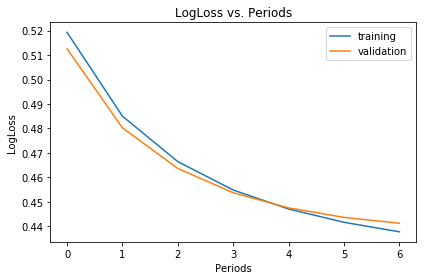

In [68]:
linear_classifier = train_linear_classifier_model(
    learning_rate=0.003,
    regularization_strength=0.1,
    steps=25000,
    batch_size=1000,
    feature_columns=construct_feature_columns(),
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)
print "Model size:", model_size(linear_classifier)